## Tarea 3 Luis altamirano 
CNN Imagenes

## Librerias:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb
import os
import re

#############################################

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC 
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

################################################

import keras
from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier

################################################

import cv2
from skimage.transform import resize
from skimage import io
import tensorflow as tf

# LINK DATA SET Y VIDEO DE DEMOSTRACIÓN:

### https://drive.google.com/drive/folders/1eAeVcDMAjZSs6eH5CvyzzFrdgTVb0Ka3?usp=sharing


## 1 - Creación de Data

### 1.1 - Importe de imagenes

In [69]:
dirname = os.path.join(os.getcwd(), 'imagenes_figuras')
imgpath = dirname + os.sep 
 
images = []
directories = []
dircount = []
prevRoot=''
cant=0
 
print("leyendo imagenes de ",imgpath)
 
for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image0 = plt.imread(filepath)
            image=cv2.resize(image0,(21,28),interpolation=cv2.INTER_CUBIC) #escalado 21x28 pixeles
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)
 
dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  C:\Users\luis\Tarea3 PDI\imagenes_figuras\
C:\Users\luis\Tarea3 PDI\imagenes_figuras\no_hay_figuras 1
C:\Users\luis\Tarea3 PDI\imagenes_figuras\triangulo 375
Directorios leidos: 2
Imagenes en cada directorio [376, 143]
suma Total de imagenes en subdirs: 519


#### Observación:
El data tiene un total de 519 imagenes, donde 376 son de imagenes que no contienen figuras y 143 son de triangulos.

Se escalan las imagenes a 21x28 pixeles para que no resulte tan pesado el programa.

### 1.2 - Etiquetas

In [70]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))
#################################################
figuras=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    figuras.append(name[len(name)-1])
    indice=indice+1
#################################################
Y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(Y)
nClasses = len(classes)
print('total de etiquetas : ', nClasses)
print('etiquetas : ', classes)

Cantidad etiquetas creadas:  519
0 no_hay_figuras
1 triangulo
total de etiquetas :  2
etiquetas :  [0 1]


### Observación:
Se establecen las etiquetas, donde el 0 representa cuando en la imagen no hay ninguna figura y 1 cuando la imagen es de un triangulo.

## 2 - Separación Dataset

In [71]:
train_X,test_X,train_Y,test_Y = train_test_split(X,Y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)
 
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.
 
# Se cambian etiquetas por one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)
 
# Se imprime las etiquetas originales y la one-hot encoding para notar la diferencia.
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])
 
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)
 
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)


Training data shape :  (415, 28, 21, 3) (415,)
Testing data shape :  (104, 28, 21, 3) (104,)
Original label: 1
After conversion to one-hot: [0. 1.]
(332, 28, 21, 3) (83, 28, 21, 3) (332, 2) (83, 2)


### Observación: 
Se pre procesan los pixeles para que tengan valores de 0 a 1 y se hace que la salida en vez de tener un valor unico, sea una matriz 1x2, esto para que pueda ser procesada por la red neuronal. 


## 3 - Diseño red neuronal

In [72]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 70 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 100 # cantidad de imágenes que se toman a la vez en memoria

In [73]:
model = Sequential()
model.add(Conv2D(700, kernel_size=(6, 6),activation='linear',padding='same',strides=(2, 2),input_shape=(21,28,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.5))
 
model.add(Flatten())
model.add(Dense(32, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5)) 
model.add(Dense(nClasses, activation='softmax'))

### Observación: 
Se aplican 700 filtros kernel para detectar las caracteristicas de las imagenes de entrenamiento y se aplica maxpooling para reducir la imagen de 21x28 a la mitad. El dropout se aplica para evitar el desvanecimiento de parametros.
Con el comando Flatten se aplana la imagen para entrar a la red neuronal densa, se aplica nuevamente Dropout para evitar el desvanecimiento y finalmente una red de salida de solo 2 neuronas por la cantidad de etiquetas que se tienen(sin figuras, triangulo).


In [74]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 11, 14, 700)       76300     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 11, 14, 700)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 7, 700)         0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 6, 7, 700)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 29400)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                940832    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 32)               

### Observación: 
La red presenta un total de 1.017.198

In [75]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

In [76]:
#Se entrena el modelo
Hist = model.fit(train_X, train_label, 
                      epochs, batch_size,
                     validation_data=(valid_X, valid_label))

Epoch 1/100
5/5 [==============================] - 1s 105ms/step - loss: 0.6465 - accuracy: 0.7048 - val_loss: 0.6493 - val_accuracy: 0.6506
Epoch 2/100
5/5 [==============================] - 0s 79ms/step - loss: 0.5892 - accuracy: 0.7440 - val_loss: 0.6256 - val_accuracy: 0.6506
Epoch 3/100
5/5 [==============================] - 0s 90ms/step - loss: 0.5706 - accuracy: 0.7440 - val_loss: 0.5949 - val_accuracy: 0.6506
Epoch 4/100
5/5 [==============================] - 0s 84ms/step - loss: 0.5493 - accuracy: 0.7440 - val_loss: 0.5672 - val_accuracy: 0.6506
Epoch 5/100
5/5 [==============================] - 0s 82ms/step - loss: 0.4955 - accuracy: 0.7560 - val_loss: 0.5407 - val_accuracy: 0.6506
Epoch 6/100
5/5 [==============================] - 0s 84ms/step - loss: 0.4786 - accuracy: 0.7651 - val_loss: 0.5159 - val_accuracy: 0.6506
Epoch 7/100
5/5 [==============================] - 0s 86ms/step - loss: 0.4465 - accuracy: 0.7590 - val_loss: 0.4819 - val_accuracy: 0.6627
Epoch 8/100
5/5 [==

## 4 - Desempeño

### 4.1 - Desempeño General

In [77]:
test_eval= model.evaluate(test_X, test_Y_one_hot, verbose=2)
train_eval= model.evaluate(train_X, train_label, verbose=2)
#se guarda modelo
model.save("modelo_figuras.h5py")

4/4 - 0s - loss: 0.0182 - accuracy: 1.0000
11/11 - 0s - loss: 0.0293 - accuracy: 0.9970
INFO:tensorflow:Assets written to: modelo_figuras.h5py\assets


In [84]:
#se carga modelo
model=keras.models.load_model('modelo_figuras.h5py')

print('Perdida Test:',test_eval[0]*100,'%')
print('Presición datos Test:',test_eval[1]*100,'%')
print('Perdida entrenamiento:',train_eval[0]*100,'%')
print('Presición datos Entrenamiento:',train_eval[1]*100,'%')

Perdida Test: 1.8231676891446114 %
Presición datos Test: 100.0 %
Perdida entrenamiento: 2.9318097978830338 %
Presición datos Entrenamiento: 99.69879388809204 %


### Observación: 
Se presenta una presición del 100% en los datos de Test.

### 4.2 - Curva de entrenamiento vs perdida en entrenamiento

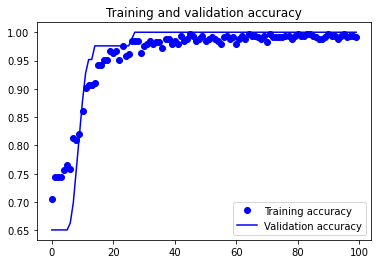

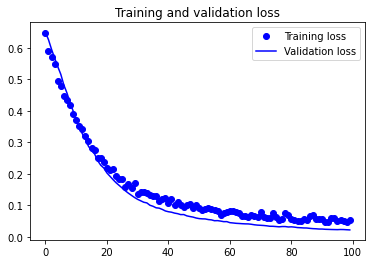

In [79]:
accuracy = Hist.history['accuracy']
val_accuracy =  Hist.history['val_accuracy']
loss =  Hist.history['loss']
val_loss =  Hist.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 5 -  Matriz de confusión

In [80]:
pred0 = model.predict(test_X)

pred=[]
test_Y1=[]

num=pred0.shape


for j in range(0,num[0]):
    
    # se crea vector predictor(0=no hay figuras, 1= triangulo)
    if pred0[j][0]>pred0[j][1]:
        a=0
        pred.append(a)
    else:
        a=1
        pred.append(a)
    
    # se crea vector valores test de salida(0=no hay figuras, 1= triangulo)
    if test_Y_one_hot[j][0]>test_Y_one_hot[j][1]:
        b=0
        test_Y1.append(b)
    else:
        b=1
        test_Y1.append(b)

## se imprime matriz
print(confusion_matrix(test_Y1,pred))
print(classification_report(test_Y1,pred))



[[77  0]
 [ 0 27]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00        27

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104



### Observación: 
Los valores de la matriz de confusión se van al 100% producto de que la presición tiene este valor. Esto no garantiza que el algoritmo tiene razon, ya que la muestra con la que se hizo la prueba es pequeña y con mas datos puede bajar un poco.

## 6 - Fotos prueba

### 6.1 - Test Triangulo 

Triangulo


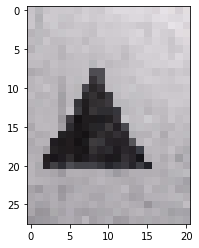

In [85]:

## imagen cuadrado

frame=cv2.imread('Test_triangulo.jpg') #lectura imagen1
image=[]
    
##se tranforma imagen para que el modelo CNN lo analice 
image1=cv2.resize(frame,(21,28),interpolation=cv2.INTER_CUBIC) #escalado 21x28 pixeles
image.append(image1)
        
X0 = np.array(image, dtype=np.uint8)
test_X0 = X0.astype('float32')
test_X0 = test_X0 / 255.    
    
##se inserta imagen en modelo
foto = model.predict(test_X0) 


 ##si no hay figuras
if foto[0][0]>foto[0][1]:
        print('no hay figuras') 
        
#si hay un triangulo
if foto[0][1]>foto[0][0]:
        print('Triangulo')




plt.imshow(image1)

##apagar camara

### 6.2 - Test sin figuras

no hay figuras


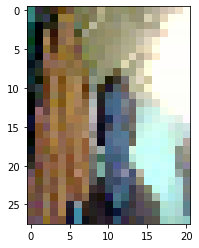

In [86]:
## imagen sin figura

frame=cv2.imread('Test_cara.jpg') #lectura imagen1
image=[]
    
##se tranforma imagen para que el modelo CNN lo analice 
image1=cv2.resize(frame,(21,28),interpolation=cv2.INTER_CUBIC) #escalado 21x28 pixeles
image.append(image1)
        
X0 = np.array(image, dtype=np.uint8)
test_X0 = X0.astype('float32')
test_X0 = test_X0 / 255.    
    
##se inserta imagen en modelo
foto = model.predict(test_X0) 


##se inserta imagen en modelo
foto = model.predict(test_X0) 


 ##si no hay figuras
if foto[0][0]>foto[0][1]:
        print('no hay figuras') 
        
#si hay un triangulo
if foto[0][1]>foto[0][0]:
        print('Triangulo')




plt.imshow(image1)



## 7 - Aplicación tiempo real

In [89]:
## capturar camara
video =cv2.VideoCapture(0)

## ciclo while para capturar los fotogramas continuamente:


while True:  
    
    ## crear frame
    check, frame = video.read()
    image=[]
    
    ##se tranforma imagen para que el modelo CNN lo analice 
    image1=cv2.resize(frame,(21,28),interpolation=cv2.INTER_CUBIC) #escalado 21x28 pixeles
    image.append(image1)
        
    X0 = np.array(image, dtype=np.uint8)
    test_X0 = X0.astype('float32')
    test_X0 = test_X0 / 255.    
    
    ##se inserta imagen en modelo
    foto = model.predict(test_X0)    
    
    ##si no hay figuras
    if foto[0][0]>foto[0][1]:
        cv2.putText(frame, 'NO HAY FIGURAS'.format(100,100),(240,100),cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,255,0),1,cv2.LINE_AA)
                       
    #si hay un triangulo
    if foto[0][1]>foto[0][0]:
        cv2.putText(frame, 'TRIANGULO'.format(100,100),(240,100),cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,255,0),1,cv2.LINE_AA)
            
    
    ##muestra imagen
    cv2.imshow('camara, presione q para finalizar',frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):  # si se apreta la tecla "q" se apaga la camara
        break
        
##apagar camara
video.release()
cv2.destroyAllWindows()

# Conclusión
Las CNN tienen un buen desempeño dependiendo de la cantidad de imagenes del dataset y de la cantidad de elementos a clasificar. En el caso de esta tarea se llego a una presición del 100% principalmente al motivo de que el data set resulto ser suficiente para solo clasificar la ausencia o no de un triangulo. En el caso de que se requiera clasificar mas elementos seria necesario aumentar la cantidad de imagenes y ajustar la estructura de la CNN.